# Import Statements

In [1]:
#Machine Learning
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

#Data
import os
import pandas as pd
import tarfile
from operator import itemgetter

#Data Visualization
import matplotlib.pyplot as plt

#Upload to Google Drive
import shutil

#Mount Google Drive for saving and retreiving .npy files to them
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load our Images and Labels

In [3]:
claire = 'APS360_Team_11_Project_Folder'
sean = 'University/Third_Year/APS360/APS360_Project'
charlotte = ''
thardchi = 'APS360'

#Please replace the variable with your custom path when you want to run the notebook
labels = np.load(f'/content/drive/MyDrive/{claire}/HurriScan_Data/IntensityRatings.npy', allow_pickle=True)
images= np.load(f'/content/drive/MyDrive/{claire}/HurriScan_Data/Images.npy', allow_pickle=True)

# Load the Data into a Dataset and also normalize the images to have values in range [0,1]

In [4]:
#Here, our pixel values were in range [0, some big number] -> make them between 0 and 1
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
new_images = rescale(images)

#Create a dictionary of image-label key value pairs (We need this to create a custom dataset)
image_data = []
for i in range(0, 2563):
  dictionary = {}
  dictionary['image'] = new_images[i]
  dictionary['label'] = labels[i]
  image_data.append(dictionary)

#Define our transforms
simple = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(301, scale=(0.8, 1.0)),
    #transforms.RandomGaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        item = self.data[index]
        image = item['image']
        #if self.transform:
            #image = self.transform(image)
        label = item['label']
        return image, label

#Create the master custom dataset
my_dataset = CustomDataset(image_data, transform=simple)

# Let us Visualize some of the data in our dataset!

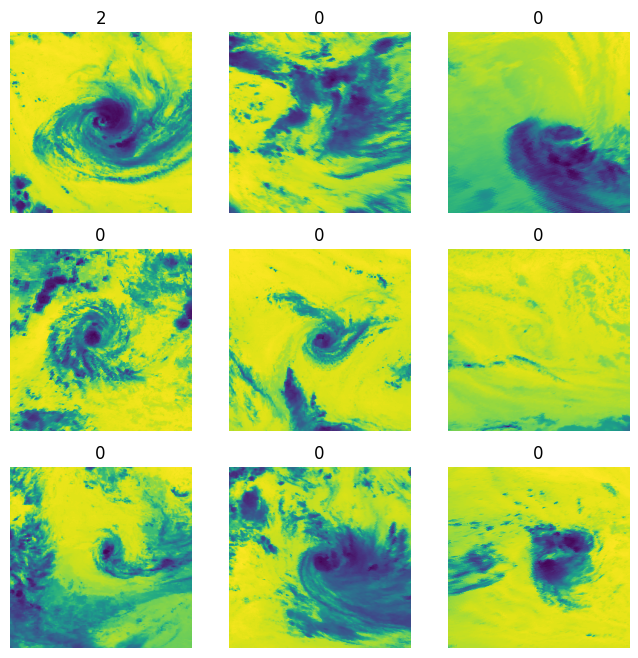

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(my_dataset), size=(1,)).item()
    img, label = my_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

# Now, we are going to Analyze and Augment our Dataset to balance it out

## Plot of the Categorical Distributions in the Entire Dataset

2563


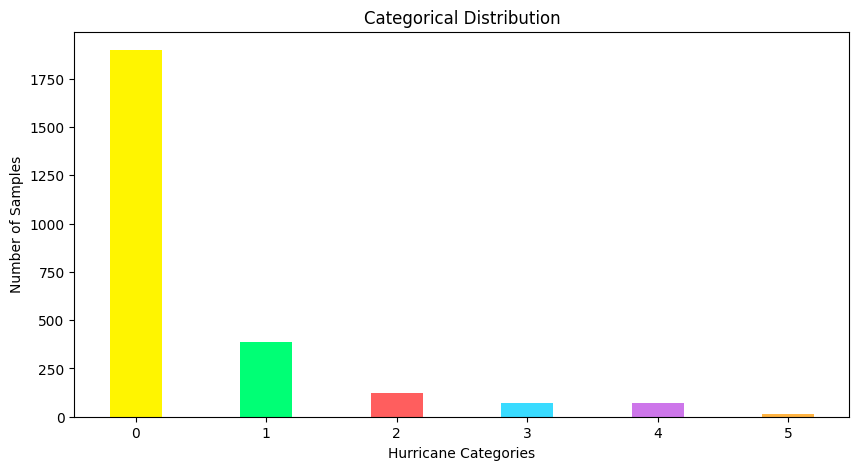

In [6]:
from collections import Counter
def plot_categories(dataset):
  labels_unique = [sample[1] for sample in dataset]
  label_counts = Counter(labels_unique)
  data = {}
  for label, count in label_counts.items():
      #print("label:", label, "count", count)
      data[label] = count
  labels_for_graph = list(data.keys())
  counts = list(data.values())
  c = ['#fff500', '#00ff75', '#cd76ea', '#ffb443', '#ff5e5e', '#39dbff']
  fig = plt.figure(figsize = (10, 5))
  plt.bar(labels_for_graph, counts, color =c, width = 0.4)
  plt.xlabel("Hurricane Categories")
  plt.ylabel("Number of Samples")
  plt.title("Categorical Distribution")
  plt.show()

print(len(my_dataset))
plot_categories(my_dataset)

# Set aside testing data

In [7]:
#Split the Data categorically
category_5 = list(filter(lambda d: d['label'] ==5, image_data))
category_4 = list(filter(lambda d: d['label'] ==4, image_data))
category_3 = list(filter(lambda d: d['label'] ==3, image_data))
category_2 = list(filter(lambda d: d['label'] ==2, image_data))
category_1 = list(filter(lambda d: d['label'] ==1, image_data))
category_0 = list(filter(lambda d: d['label'] ==0, image_data))

#Now, Set aside a portion of the testing data (15%).
testing_data = []
testing_data.extend(category_5[0:5])
testing_data.extend(category_4[0:30])
testing_data.extend(category_3[0:30])
testing_data.extend(category_2[0:50])
testing_data.extend(category_1[0:70])
testing_data.extend(category_0[0:200])

test_dataset = CustomDataset(testing_data, transform=simple)
print(len(test_dataset))

385


## Plot of the categorical distribution in the Testing Dataset

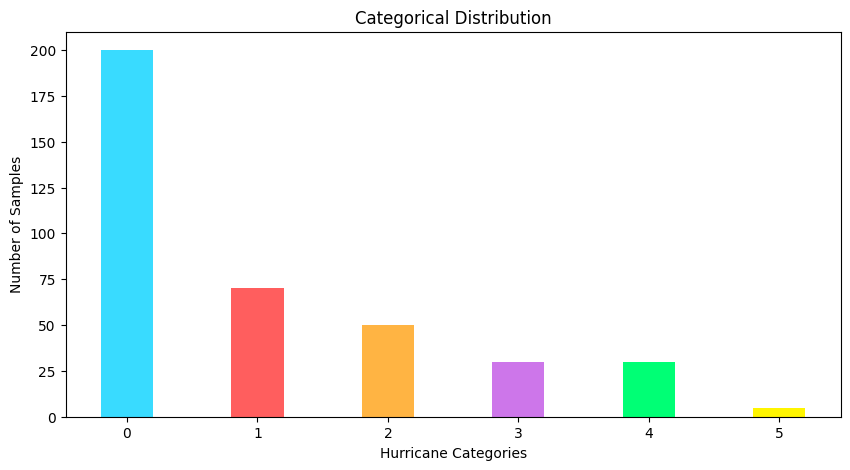

In [8]:
plot_categories(test_dataset)

# Form the Validation/Training Datasets

In [9]:
#Remove The testing data from the lists
category_5 = category_5[5:]
category_4 = category_4[30:]
category_3 = category_3[30:]
category_2 = category_2[50:]
category_1 = category_1[70:]
category_0 = category_0[200:]

#Merge the lists back together
image_data_no_test = []
image_data_no_test.extend(category_5)
image_data_no_test.extend(category_4)
image_data_no_test.extend(category_3)
image_data_no_test.extend(category_2)
image_data_no_test.extend(category_1)
image_data_no_test.extend(category_0)
print(len(image_data_no_test))

#Oversample the master dataset from which we will derive the training and validation data
def overSample(target_class, oversampling_factor, dataset):
  target_class = target_class
  oversampling_factor = oversampling_factor
  oversampled_data = []
  for index in range(len(dataset)):
    entry = dataset[index]
    dictionary_copy = {'image':entry['image'], 'label':entry['label']}
    oversampled_data.append(dictionary_copy)
    if entry['label'] == target_class:
        for _ in range(oversampling_factor - 1):
            dictionary_copy = {'image':entry['image'], 'label':entry['label']}
            oversampled_data.append(dictionary_copy)
  return oversampled_data

oversampled_image_data = []
oversampled_image_data = list(overSample(5, 67, image_data_no_test))
oversampled_image_data = list(overSample(4, 14, oversampled_image_data))
oversampled_image_data = list(overSample(3, 14, oversampled_image_data))
oversampled_image_data = list(overSample(2, 9, oversampled_image_data))
oversampled_image_data = list(overSample(1, 3, oversampled_image_data))

#Apply augmentations to the training and transform data
my_dataset_2 = CustomDataset(oversampled_image_data, transform=augmentations)

2178


# Plot of the Categorical Distributions in the Validation/Testing Dataset

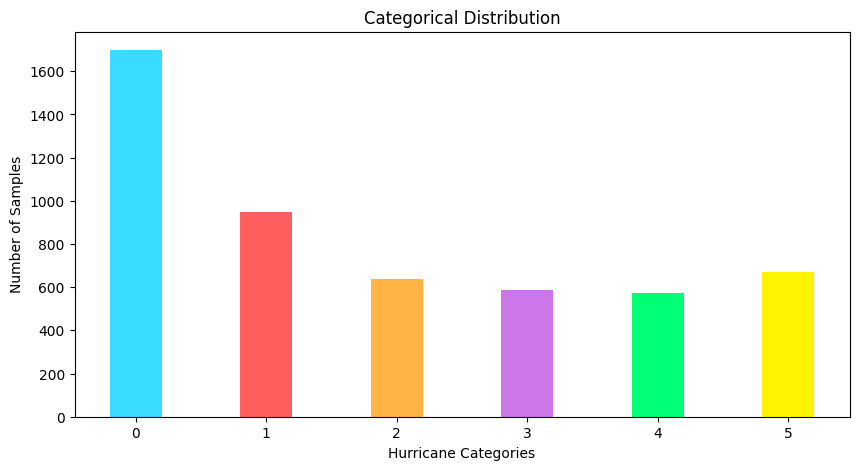

In [10]:
plot_categories(my_dataset_2)

# Split the Data: Now that we have a balanced dataset, let us split it

3070
385


<Figure size 2500x1000 with 0 Axes>

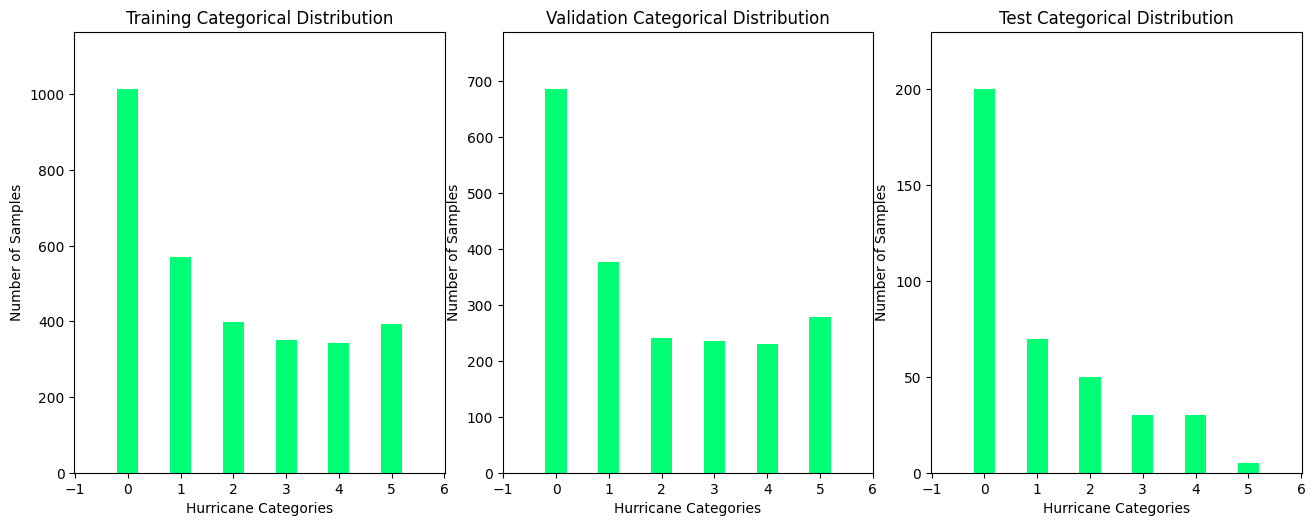

In [11]:
#Split into test, train, validation
train_size = int(0.6 * len(my_dataset_2))
validation_size = len(my_dataset_2) - train_size
train_dataset,validation_dataset = torch.utils.data.random_split(my_dataset_2, [train_size, validation_size])

print(len(train_dataset))
print(len(test_dataset))

dataset_indices = [train_dataset, validation_dataset, test_dataset]
titles = ["Training Categorical Distribution", "Validation Categorical Distribution", "Test Categorical Distribution"]
figure = plt.figure(figsize=(25, 10))
cols, rows = 3, 1
fig, ax = plt.subplots(1, 3, figsize=(13,5))
fig.tight_layout()
for i in range(0, cols*rows):
    data = {}
    plottable_dataset = dataset_indices[i]
    labels_unique = [sample[1] for sample in plottable_dataset]
    label_counts = Counter(labels_unique)
    for label, count in label_counts.items():
      data[label] = count
    labels_for_graph = list(data.keys())
    counts = list(data.values())
    ax[i].margins(0.15) # 15% padding in all directions
    c = ['#00ff75']
    ax[i].set_xlabel("Hurricane Categories")
    ax[i].bar(labels_for_graph, counts, color =c, width = 0.4)
    ax[i].set_ylabel("Number of Samples")
    ax[i].set_title(titles[i])
    fig.show()

In [12]:
print("There are", len(train_dataset), "training examples.")
print("There are", len(validation_dataset), "validation examples.")
print("There are", len(test_dataset), "test examples.")

There are 3070 training examples.
There are 2047 validation examples.
There are 385 test examples.


# Let us Define our Neural Network

In [13]:
#Define our Neural Network Model
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(51840, 32)
        self.fc2 = nn.Linear(32, 6)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 51840)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Instantiate the model
model = LargeNet()
train_dataset.transform = augmentations #Apply the augmentations to the images
train_dataloader = DataLoader(train_dataset)

#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Train the Model
num_epochs = 10
correct = 0
total = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total

    #print(f"Accuracy: {accuracy}%")
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)} Error: {1-accuracy}")

print("Training finished")

Epoch 1, Loss: 1.7127621428100606 Error: 0.6781758957654723
Epoch 2, Loss: 1.6749632135828416 Error: 0.669543973941368
Epoch 3, Loss: 1.6269768507052054 Error: 0.6604777415852334
Epoch 4, Loss: 1.5961648787004414 Error: 0.6517915309446254
Epoch 5, Loss: 1.6166846033333984 Error: 0.6461237785016287
Epoch 6, Loss: 1.574477141647663 Error: 0.641585233441911
Epoch 7, Loss: 1.5624198778875837 Error: 0.637785016286645
Epoch 8, Loss: 1.560850991418872 Error: 0.6348534201954397
Epoch 9, Loss: 1.555920692077003 Error: 0.6324285197249366
Epoch 10, Loss: 1.5813792391013914 Error: 0.6308469055374593
Training finished
